In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
train_weather = pd.read_parquet('/app/data/train_with_weather_cleaned_20240514.parquet', engine='fastparquet')
test_weather = pd.read_parquet('/app/data/test_with_weather_cleaned_20240514.parquet', engine='fastparquet')
# train_weather.to_csv('/app/data/tableau_features_all.csv', index=False)

# Drop 'Date' from both train and test datasets
train_df = train_weather.drop('Date', axis=1)
test_df = test_weather.drop('Date', axis=1)

train_df = train_df.drop('Year', axis=1)
test_df = test_df.drop('Year', axis=1)

# Separate the target variable
X_train = train_df.drop('WnvPresent', axis=1)
y_train = train_weather['WnvPresent']

# Split training data into training and test
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_train, y_train, test_size=.3, random_state=42)

# Ensures each fold is representative of the overall class distribution
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# AdaBoostClassifier performed best on the resampled set using the default model.
model = AdaBoostClassifier()

# Balance classes using SMOTEENN. Oversamples the minority class and undersamples the majority class
print(f'Original dataset shape {Counter(y_train_o)}')
X_train_b_float = X_train_o.astype(float)
oversample = SMOTEENN(random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train_b_float, y_train_o)
print(f'Resampled dataset shape {Counter(y_resampled)}')

Original dataset shape Counter({0: 6969, 1: 385})
Resampled dataset shape Counter({1: 6005, 0: 5910})


In [4]:
# REDUCING THE FEATURE DIMENSIONALITY TO THE 9 FEATURES FOUND USING RFE ###

features = ['Species', 'AddressAccuracy', 'NumMosquitos', 'Day_of_Week', 'Location_Cluster', 'wnv_case_proportion', 'Sunrise', 'SeaLevel', 'PrecipTotal_lag1']
X_resampled = X_resampled[features]
X_test_o = X_test_o[features]

                    ROC AUC  Precision  Recall  F1 Score         Confusion Matrix
Model                                                                            
AdaBoostClassifier     0.88       0.25    0.57      0.34  [[2697, 289], [72, 94]]


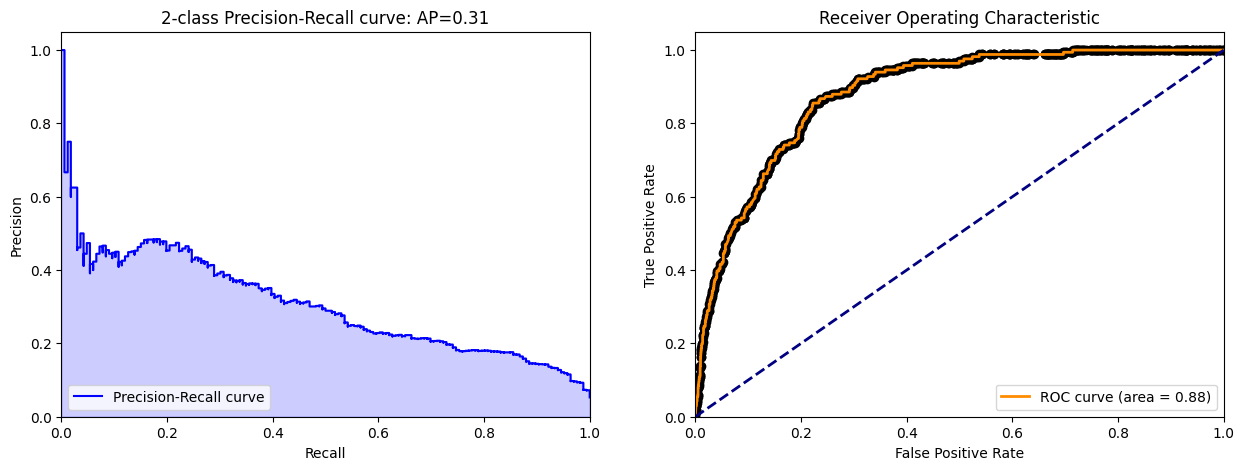

               Feature  Importance
0              Species        0.22
4     Location_Cluster        0.19
1      AddressAccuracy        0.17
3          Day_of_Week        0.09
6              Sunrise        0.09
5  wnv_case_proportion        0.08
2         NumMosquitos        0.07
7             SeaLevel        0.05
8     PrecipTotal_lag1        0.04


In [5]:
### TRAIN ON FULL TRAINING DATASET AND TEST OF RPEVIOUSLY UNUSED TEST DATASET ###
"""
The hyperparameter tuning using grid search did not improve the performance of the model so the default hyperparameter values were kept.
"""

results_df = pd.DataFrame(columns=['Model', 'ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix'])

model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100, learning_rate=1.0, random_state=42)

# Retrain AdaBoostClassifier with the full training set
model.fit(X_resampled, y_resampled)

# Predict probabilities and classes
predictions = model.predict(X_test_o)
probs = model.predict_proba(X_test_o)[:, 1]

results = pd.DataFrame({
        'Model': ['AdaBoostClassifier'],
        'ROC AUC': [roc_auc_score(y_test_o, probs)],
        'Precision': [precision_score(y_test_o, predictions, zero_division=0)],
        'Recall': [recall_score(y_test_o, predictions)],
        'F1 Score': [f1_score(y_test_o, predictions)],
        'Confusion Matrix': [confusion_matrix(y_test_o, predictions)]
    })

results_df = pd.concat([results_df, results], ignore_index=True)

print(results.set_index('Model'))

# Compute ROC curve and ROC area
fpr, tpr, roc_thresholds = roc_curve(y_test_o, probs)
roc_auc = auc(fpr, tpr)

# # Create a DataFrame
# roc_df = pd.DataFrame({
#     'False Positive Rate': fpr,
#     'True Positive Rate': tpr,
#     'Threshold': roc_thresholds
# })

# # Save the DataFrame to a CSV file
# roc_df.to_csv('/app/data/tableau_roc_tpr_fpr.csv', index=False)

# Compute precision-recall pairs for different probability thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_test_o, probs)
average_precision = average_precision_score(y_test_o, probs)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.step(recall, precision, where='post', color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
plt.legend(loc="lower left")

# ROC curve plot
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr, tpr, marker='o', color='black')  # mark each threshold
# for i, threshold in enumerate(roc_thresholds):
#     if i % 11 == 0:
#         plt.annotate(f"{threshold:.2f}", (fpr[i]+0.01, tpr[i]-0.02))  # annotate thresholds
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X_test_o.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)  # Sorting the features by importance
# feature_importances.to_csv('/app/data/tableau_feature_importances.csv', index=False)

# Displaying the DataFrame
print(feature_importances)


In [6]:
# Levels of TPR we are interested in
tpr_levels = [0.8, 0.85, 0.9, 0.95, 1.0]

# Find the first threshold where the true positive rate (TPR) is above a specified level
thresholds_for_tprs = {level: roc_thresholds[np.where(tpr >= level)[0][0]] for level in tpr_levels if np.where(tpr >= level)[0].size > 0}

# Print classification reports for each threshold
for level, threshold in thresholds_for_tprs.items():
    # Generate predictions based on the current threshold, i.e. True if the predicted probability is greater than threshold.
    predictions = [1 if p >= threshold else 0 for p in probs]
    
    # Print the classification report
    print(f"Threshold corresponding to TPR >= {level*100}%: {threshold:.4f}")
    print(classification_report(y_test_o, predictions))
    print("-" * 80)


Threshold corresponding to TPR >= 80.0%: 0.4959
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      2986
           1       0.18      0.80      0.29       166

    accuracy                           0.80      3152
   macro avg       0.58      0.80      0.59      3152
weighted avg       0.94      0.80      0.85      3152

--------------------------------------------------------------------------------
Threshold corresponding to TPR >= 85.0%: 0.4950
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      2986
           1       0.18      0.86      0.29       166

    accuracy                           0.78      3152
   macro avg       0.58      0.82      0.58      3152
weighted avg       0.95      0.78      0.84      3152

--------------------------------------------------------------------------------
Threshold corresponding to TPR >= 90.0%: 0.4924
              precision    recall  f1-sc

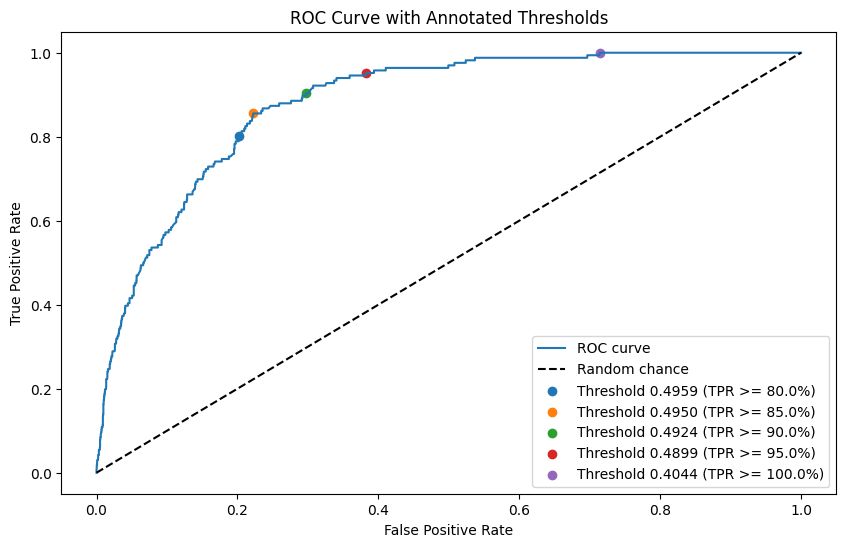

In [7]:
fpr, tpr, roc_thresholds = roc_curve(y_test_o, probs)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

highlight_points = []
# Annotate the thresholds corresponding to specified TPR levels
for level, threshold in thresholds_for_tprs.items():
    idx = np.where(roc_thresholds == threshold)[0][0]
    plt.scatter(fpr[idx], tpr[idx], marker='o', label=f'Threshold {threshold:.4f} (TPR >= {level*100}%)')
    highlight_points.append((fpr[idx], tpr[idx], roc_thresholds[idx], level))

# highlight_df = pd.DataFrame(highlight_points, columns=['FPR', 'TPR', 'Threshold', 'TPR_Level'])
# highlight_df.to_csv('/app/data/tableau_roc_tpr_fpr_thresholds.csv', index=False)

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Annotated Thresholds')
plt.legend(loc='best')
plt.show()

In [35]:
# List to store confusion matrix data
confusion_data = []

# Print confusion matrix for each threshold
for level, threshold in thresholds_for_tprs.items():
    predictions = [1 if p >= threshold else 0 for p in probs]
    cm = confusion_matrix(y_test_o, predictions)
    tn, fp, fn, tp = cm.ravel()

    # Append data to the list
    confusion_data.append([threshold, level, tn, fp, fn, tp])

    print(f"Confusion Matrix for Threshold {threshold:.4f} (TPR >= {level*100}%):")
    # if level == 0.8:
    print(f"[{tn}\t{fp}]\t--> E.g. {tn} traps correctly predicted as not needing tests, saving money, but {fp} ({fp/(fp+tn)*100:.2f}%) traps incorrectly predicted as needing tests, unnecessarily costing extra to test them.")
    print(f"[{fn}\t{tp}]\t--> E.g. {tp} traps correctly predicted as needing tests, ensuring public safety, but {fn} ({fn/(tp+fn)*100:.2f}%) traps incorrectly predicted as not needing tests, potentially missing the virus.")
    # else:
    #     print(f"[{tn}\t{fp}]")
    #     print(f"[{fn}\t{tp}]")
 
    print("-" * 80)

# # Convert the list to a DataFrame
# confusion_df = pd.DataFrame(confusion_data, columns=['Threshold', 'TPR_Level', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'])

# # Save the DataFrame to a CSV file
# confusion_df.to_csv('/app/data/tableau_confusion_matrix.csv', index=False)


Confusion Matrix for Threshold 0.4959 (TPR >= 80.0%):
[2382	604]	--> E.g. 2382 traps correctly predicted as not needing tests, saving money, but 604 (20.23%) traps incorrectly predicted as needing tests, unnecessarily costing extra to test them.
[33	133]	--> E.g. 133 traps correctly predicted as needing tests, ensuring public safety, but 33 (19.88%) traps incorrectly predicted as not needing tests, potentially missing the virus.
--------------------------------------------------------------------------------
Confusion Matrix for Threshold 0.4950 (TPR >= 85.0%):
[2322	664]	--> E.g. 2322 traps correctly predicted as not needing tests, saving money, but 664 (22.24%) traps incorrectly predicted as needing tests, unnecessarily costing extra to test them.
[24	142]	--> E.g. 142 traps correctly predicted as needing tests, ensuring public safety, but 24 (14.46%) traps incorrectly predicted as not needing tests, potentially missing the virus.
-----------------------------------------------------

In [34]:
# Assumptions:
# - The model is predicting whether to test a trap for the presence of a virus.
# - We aim to calculate the yearly savings by not testing certain traps based on the model's predictions.
# - We assume each trap costs $500 per year to test.

# Calculate the total number of tests each year
total_tests_per_year = train_weather.groupby('Year').size()
avg_tests_per_year = total_tests_per_year.mean()
print(f'\nAverage tests per year: {avg_tests_per_year}')

print(f"\nEstimated Yearly Savings: Amount the City of Chicago could save by not testing mosquito traps predicted to be negative for the virus while correctly predicting {level*100:.0f}% of positive cases.")

# Data to store TPR and Yearly Savings
tpr_savings_data = []

# Print average yearly savings for each threshold
for level, threshold in thresholds_for_tprs.items():
    # Generate predictions based on the current threshold
    predictions = [1 if p >= threshold else 0 for p in probs]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_o, predictions)
    
    # Calculate the number of traps that won't be tested if the city follows the recommendations from this model
    not_tested = cm[0, 0] + cm[1, 0]  # True Negatives (TN) + False Negatives (FN)

    # Calculate the average yearly savings
    average_yearly_savings = (not_tested / len(y_test_o)) * avg_tests_per_year * 500

    # Append TPR and savings data to the list
    tpr_savings_data.append([level, average_yearly_savings])

    print(f"\nPercentage of traps with a negative prediction: {not_tested} of {len(y_test_o)} ({not_tested / len(y_test_o)*100:.2f}%)")
    # Print the results
    print(f"Threshold: {threshold:.4f} (TPR >= {level*100}%)")
    print(f"Estimated Yearly Savings: ${average_yearly_savings:,.2f}")
    print("-" * 80)  # Print a separator for readability

# # Convert the list to a DataFrame
# tpr_savings_df = pd.DataFrame(tpr_savings_data, columns=['TPR', 'Yearly Savings'])

# # Save the DataFrame to a CSV file
# tpr_savings_df.to_csv('/app/data/tableau_tpr_savings_data.csv', index=False)




Average tests per year: 2626.5

Estimated Yearly Savings: Amount the City of Chicago could save by not testing mosquito traps predicted to be negative for the virus while correctly predicting 100% of positive cases.

Percentage of traps with a negative prediction: 2415 of 3152 (76.62%)
Threshold: 0.4959 (TPR >= 80.0%)
Estimated Yearly Savings: $1,006,186.15
--------------------------------------------------------------------------------

Percentage of traps with a negative prediction: 2346 of 3152 (74.43%)
Threshold: 0.4950 (TPR >= 85.0%)
Estimated Yearly Savings: $977,437.98
--------------------------------------------------------------------------------

Percentage of traps with a negative prediction: 2113 of 3152 (67.04%)
Threshold: 0.4924 (TPR >= 90.0%)
Estimated Yearly Savings: $880,360.80
--------------------------------------------------------------------------------

Percentage of traps with a negative prediction: 1852 of 3152 (58.76%)
Threshold: 0.4899 (TPR >= 95.0%)
Estimate